## Imports

In [5]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Utilities

You will then define some utility functions to make the code more organized. First up is the plotting function you also used in the previous lab.

In [23]:
def plot_series(time, series, format="-", start=0, end=None):
    """
    Visualizes time series data

    Args:
      time (array of int) - contains the time steps
      series (array of int) - contains the measurements for each time step
      format - line style when plotting the graph
      label - tag for the line
      start - first time step to plot
      end - last time step to plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))
    
    if type(series) is tuple:

      for series_num in series:
        # Plot the time series data
        plt.plot(time[start:end], series_num[start:end], format)

    else:
      # Plot the time series data
      plt.plot(time[start:end], series[start:end], format)

    # Label the x-axis
    plt.xlabel("Time")

    # Label the y-axis
    plt.ylabel("Value")

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

You will also place the functions to generate your synthetic data here. For this lab, you will just need trend, seasonality, and noise. Feel free to add others later in case you want a more challenging task.

In [3]:
def trend(time, slope=0):
    """
    Generates synthetic data that follows a straight line given a slope value.

    Args:
      time (array of int) - contains the time steps
      slope (float) - determines the direction and steepness of the line

    Returns:
      series (array of float) - measurements that follow a straight line
    """

    # Compute the linear series given the slope
    series = slope * time

    return series

def seasonal_pattern(season_time):
    """
    Just an arbitrary pattern, you can change it if you wish
    
    Args:
      season_time (array of float) - contains the measurements per time step

    Returns:
      data_pattern (array of float) -  contains revised measurement values according 
                                  to the defined pattern
    """

    # Generate the values using an arbitrary pattern
    data_pattern = np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))
    
    return data_pattern

def seasonality(time, period, amplitude=1, phase=0):
    """
    Repeats the same pattern at each period

    Args:
      time (array of int) - contains the time steps
      period (int) - number of time steps before the pattern repeats
      amplitude (int) - peak measured value in a period
      phase (int) - number of time steps to shift the measured values

    Returns:
      data_pattern (array of float) - seasonal data scaled by the defined amplitude
    """
    
    # Define the measured values per period
    season_time = ((time + phase) % period) / period

    # Generates the seasonal data scaled by the defined amplitude
    data_pattern = amplitude * seasonal_pattern(season_time)

    return data_pattern

def noise(time, noise_level=1, seed=None):
    """Generates a normally distributed noisy signal

    Args:
      time (array of int) - contains the time steps
      noise_level (float) - scaling factor for the generated signal
      seed (int) - number generator seed for repeatability

    Returns:
      noise (array of float) - the noisy signal
    """

    # Initialize the random number generator
    rnd = np.random.RandomState(seed)

    # Generate a random number for each time step and scale by the noise level
    noise = rnd.randn(len(time)) * noise_level
    
    return noise

## Generate the synthetic data

You can then use the utility functions above to generate the synthetic data. This will start at a baseline then trend upwards with a seasonal pattern every 365 steps. You will also add some noise because real world data is often noisy as well.

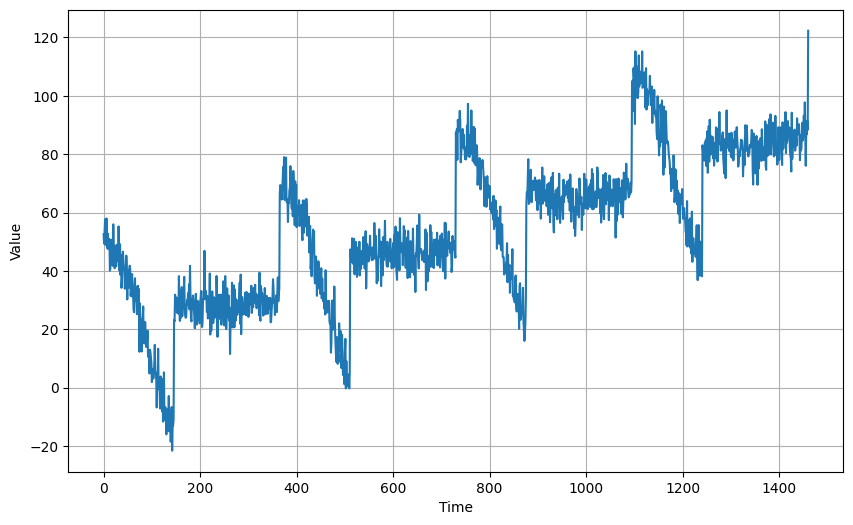

In [24]:
# Parameters
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

# Update with noise
series += noise(time, noise_level, seed=42)

# Plot the results
plot_series(time, series)

## Split the Dataset

Next up, you will split the data above into training and validation sets. You will take the first 1,000 points for training while the rest is for validation.

In [25]:
# Define the split time
split_time = 1000

# Get the train set
time_train = time[:split_time]
x_train  = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

You can inspect these sets visually by using the same utility function for plotting. Notice that in general, the validation set has higher values (i.e. y-axis) than those in the training set. Your model should be able to predict those values just by learning from the trend and seasonality of the training set.

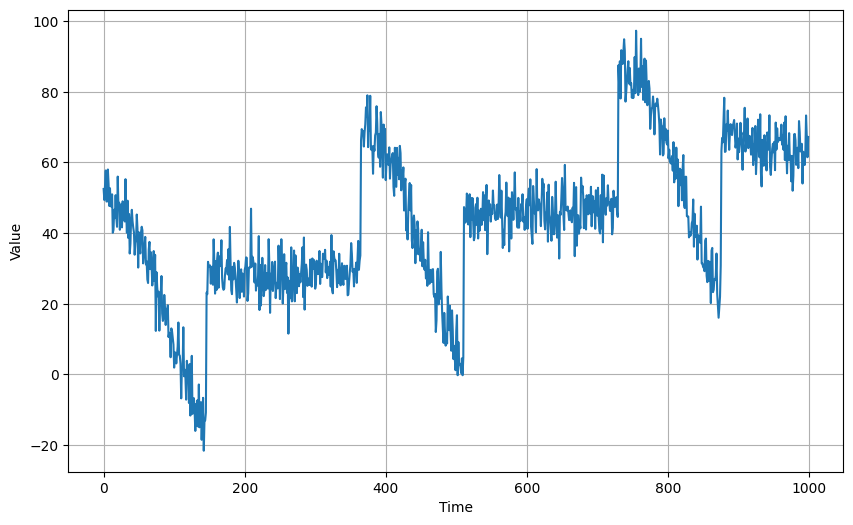

In [26]:
# Plot the train set
plot_series(time_train, x_train)

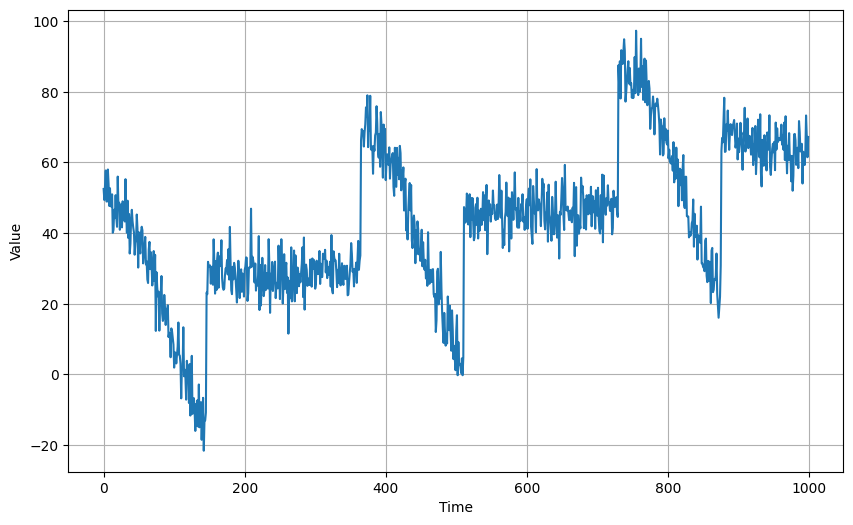

In [10]:
# Plot validation set
plot_series(time_valid, x_valid)

# Naive Forecast

As a baseline, you can do a naive forecast where you assume that the next value will be the same as the previous time step. You can slice the original series like below and print some values as a sanity check. The next time step value should be identical to the ground truth at the previous time step.

In [27]:
# Generate the naive forecast
naive_forecast = series[split_time - 1:-1]

# Define time step
time_step = 100

# Print values
print(f'ground truth at time step {time_step}: {x_valid[time_step]}')
print(f'prediction at time step {time_step + 1}: {naive_forecast[time_step + 1]}')


ground truth at time step 100: 109.84197998046875
prediction at time step 101: 109.84197998046875


You can see this visually with the `plot_series()` function you defined earlier.

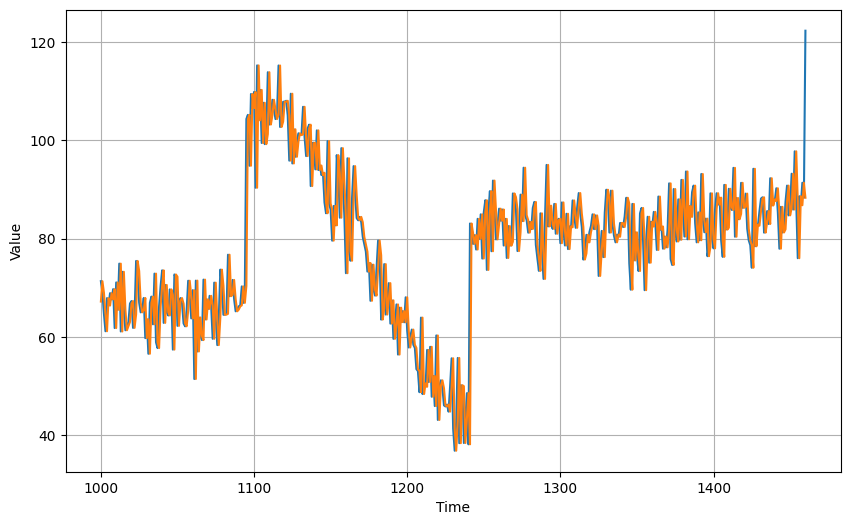

In [28]:
# Plot the results
plot_series(time_valid, (x_valid, naive_forecast))

You can zoom in at the start of the validation period to see that the naive forecast lags 1 step behind the time series.

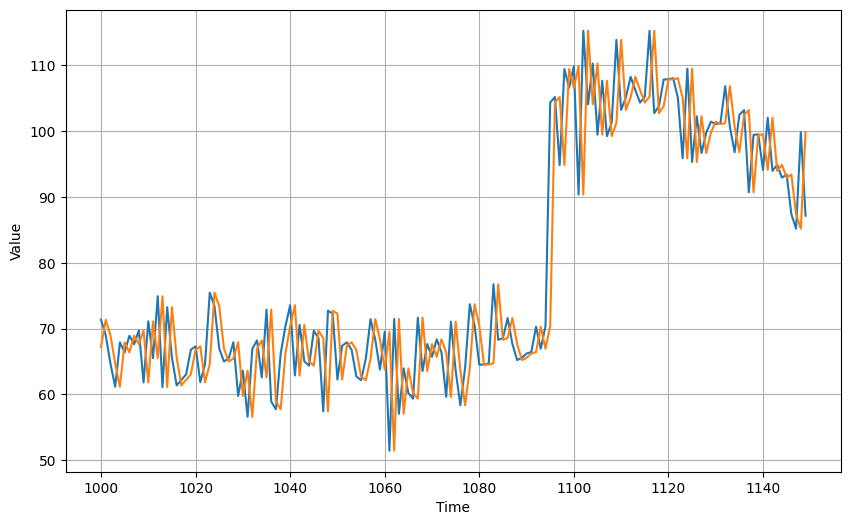

In [29]:
## Zooming in 
plot_series(time_valid, (x_valid, naive_forecast), start = 0, end = 150)

### Computing Metrics

Now you will compute the [mean squared error](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/mean_squared_error) and the [mean absolute error](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/mean_absolute_error) between the forecasts and the predictions in the validation period. These are available via the [`tf.keras.metrics`](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/) API. 

In [31]:
print(tf.keras.metrics.mean_squared_error(x_valid, naive_forecast).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, naive_forecast).numpy())


61.827534
5.937908
